# Homework week 5

The purpose of this notebook is to do the Statistical Rethinking 2022 [homework](https://github.com/rmcelreath/stat_rethinking_2022/tree/main/homework) using Python.

In [194]:
import arviz as az
import daft
from causalgraphicalmodels import CausalGraphicalModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from scipy.special import expit
import seaborn as sns
import statsmodels.api as sm

<IPython.core.display.Javascript object>

In [3]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [4]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Q1

The data in `data(NWOGrants)` are outcomes for scientific funding applications
for the Netherlands Organization for Scientific Research (NWO) from 2010–2012
(see van der Lee and Ellemers doi:10.1073/pnas.1510159112). These data have a
very similar structure to the UCBAdmit data discussed in Chapter 11. Draw a DAG
for this sample and then use one or more binomial GLMs to estimate the TOTAL
causal effect of gender on grant awards.

## Answer

The DAG from Chapter 11 can essentially be re-used since the `discipline` field can be used instead of `department` and `award` instead of `admit`.

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


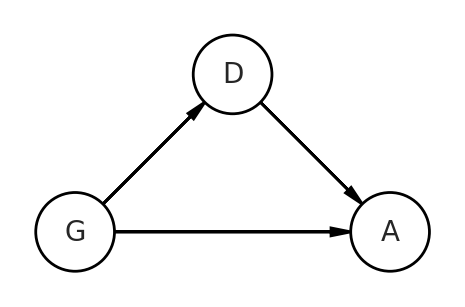

<IPython.core.display.Javascript object>

In [ ]:
dag = CausalGraphicalModel(
    nodes=["G", "D", "A"],
    edges=[
        ("G", "D"),
        ("D", "A"),
        ("G", "A"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "D": (1, 1),
    "G": (0, 0),
    "A": (2, 0),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

### Replicate UCB data

In [22]:
# input data
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'
# df_grants = pd.read_csv(DATA_DIR + "NWOGrants.csv", sep=";", header=0)
df_grants = pd.read_csv(DATA_DIR + "UCBadmit.csv", sep=";", header=0)
df_grants.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


<IPython.core.display.Javascript object>

Therefore, to get the total causal effect, we simply include gender in the model and not stratify by department (or discipline in the award data).


$$ A \sim \text{Binomial}(n_{i}, p_{i}) $$
$$ \text{logit}(p) = \alpha_{GID}$$
$$ \alpha_{j} \sim \text{Normal}(0, 1.5) $$


In [25]:
# index encode variables
df_grants['gender_ind'] = pd.Categorical(df_grants['applicant.gender'], categories=["male", "female"]).codes
df_grants['dept_ind'] = pd.Categorical(df_grants['dept']).codes

<IPython.core.display.Javascript object>

In [26]:
df_grants.head()

,dept,applicant.gender,admit,reject,applications,gender_ind,dept_ind
1,A,male,512,313,825,0,0
2,A,female,89,19,108,1,0
3,B,male,353,207,560,0,1
4,B,female,17,8,25,1,1
5,C,male,120,205,325,0,2


<IPython.core.display.Javascript object>

In [27]:
# write model
with pm.Model() as mq1:

    # Priors
    a = pm.Normal("a", mu=0, sd=1.5, shape=2)

    # linear model (mu is deterministic)
    p = pm.Deterministic("p", pm.math.invlogit(a[df_grants["gender_ind"]]))

    # likelihood
    award = pm.Binomial("award", n=df_grants['applications'], p=p, observed=df_grants['admit'])

    # generate posterior and sample
    idata_mq1 = pm.sample(1000, tune=1000, return_inferencedata=True, progressbar=False)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


<IPython.core.display.Javascript object>

In [28]:
az.summary(idata_mq1, var_names='a')

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.221,0.039,-0.281,-0.159,0.001,0.000,3442.0,3436.0,3436.0,3051.0,1.0
a[1],-0.830,0.049,-0.912,-0.756,0.001,0.001,3426.0,3426.0,3432.0,2936.0,1.0


<IPython.core.display.Javascript object>

### Grant awards

In [30]:
# input data
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'
df_grants = pd.read_csv(DATA_DIR + "NWOGrants.csv", sep=";", header=0)
df_grants.head()

,discipline,gender,applications,awards
0,Chemical sciences,m,83,22
1,Chemical sciences,f,39,10
2,Physical sciences,m,135,26
3,Physical sciences,f,39,9
4,Physics,m,67,18


<IPython.core.display.Javascript object>

In [34]:
# index encode variables
df_grants['gender_ind'] = pd.Categorical(df_grants['gender'], categories=["m", "f"]).codes
df_grants['discipline_ind'] = pd.Categorical(df_grants['discipline']).codes

<IPython.core.display.Javascript object>

In [36]:
# write model
with pm.Model() as mq1b:

    # Priors
    a = pm.Normal("a", mu=0, sd=1.5, shape=2)

    # linear model (mu is deterministic)
    p = pm.Deterministic("p", pm.math.invlogit(a[df_grants["gender_ind"]]))

    # likelihood
    award = pm.Binomial("award", n=df_grants['applications'], p=p, observed=df_grants['awards'])

    # generate posterior and sample
    idata_mq1b = pm.sample(1000, tune=1000, return_inferencedata=True, progressbar=False)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


<IPython.core.display.Javascript object>

In [38]:
az.summary(idata_mq1b, var_names='a')

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.535,0.066,-1.638,-1.431,0.001,0.001,3693.0,3664.0,3708.0,2773.0,1.0
a[1],-1.736,0.083,-1.875,-1.612,0.001,0.001,3616.0,3616.0,3611.0,2649.0,1.0


<IPython.core.display.Javascript object>

Look more at [what I did last year](https://github.com/benslack19/stats_rethinking/blob/main/SR_notebooks_2021/stats_rethinking_ch11_hw06.ipynb).

In [237]:
idata_mq1b_df = idata_mq1b.to_dataframe()
idata_mq1b_df.head()

,chain,draw,"(posterior, a[0], 0)","(posterior, a[1], 1)","(posterior, p[0], 0)","(posterior, p[10], 10)","(posterior, p[11], 11)","(posterior, p[12], 12)","(posterior, p[13], 13)","(posterior, p[14], 14)",...,"(sample_stats, step_size_bar)","(sample_stats, energy)","(sample_stats, lp)","(sample_stats, energy_error)","(sample_stats, process_time_diff)","(sample_stats, perf_counter_start)","(sample_stats, mean_tree_accept)","(sample_stats, diverging)","(sample_stats, max_energy_error)","(sample_stats, step_size)"
0,0,0,-1.557060,-1.726432,0.174069,0.174069,0.151045,0.174069,0.151045,0.174069,...,1.218064,65.108397,-65.057294,0.016140,0.000457,468.251165,0.978434,False,0.028087,1.142159
1,0,1,-1.557060,-1.726432,0.174069,0.174069,0.151045,0.174069,0.151045,0.174069,...,1.218064,65.582284,-65.057294,0.000000,0.000214,468.251724,0.742179,False,0.298165,1.142159
2,0,2,-1.519500,-1.753968,0.179535,0.179535,0.147547,0.179535,0.147547,0.179535,...,1.218064,65.078283,-65.007525,-0.019402,0.000468,468.252107,0.999606,False,-0.019402,1.142159
3,0,3,-1.509418,-1.780629,0.181025,0.181025,0.144226,0.181025,0.144226,0.181025,...,1.218064,65.171804,-65.168094,0.055607,0.000262,468.252713,0.945911,False,0.055607,1.142159
4,0,4,-1.548327,-1.734039,0.175328,0.175328,0.150072,0.175328,0.150072,0.175328,...,1.218064,65.250460,-65.004794,-0.058119,0.000457,468.253073,0.982631,False,-0.058119,1.142159


<IPython.core.display.Javascript object>

In [238]:
idata_mq1b_df.columns

Index([                               'chain',
                                       'draw',
                     ('posterior', 'a[0]', 0),
                     ('posterior', 'a[1]', 1),
                     ('posterior', 'p[0]', 0),
                   ('posterior', 'p[10]', 10),
                   ('posterior', 'p[11]', 11),
                   ('posterior', 'p[12]', 12),
                   ('posterior', 'p[13]', 13),
                   ('posterior', 'p[14]', 14),
                   ('posterior', 'p[15]', 15),
                   ('posterior', 'p[16]', 16),
                   ('posterior', 'p[17]', 17),
                     ('posterior', 'p[1]', 1),
                     ('posterior', 'p[2]', 2),
                     ('posterior', 'p[3]', 3),
                     ('posterior', 'p[4]', 4),
                     ('posterior', 'p[5]', 5),
                     ('posterior', 'p[6]', 6),
                     ('posterior', 'p[7]', 7),
                     ('posterior', 'p[8]', 8),
             

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'difference'),
 Text(0, 0.5, 'density'),
 Text(0.5, 1.0, 'Gender diff (F-M)')]

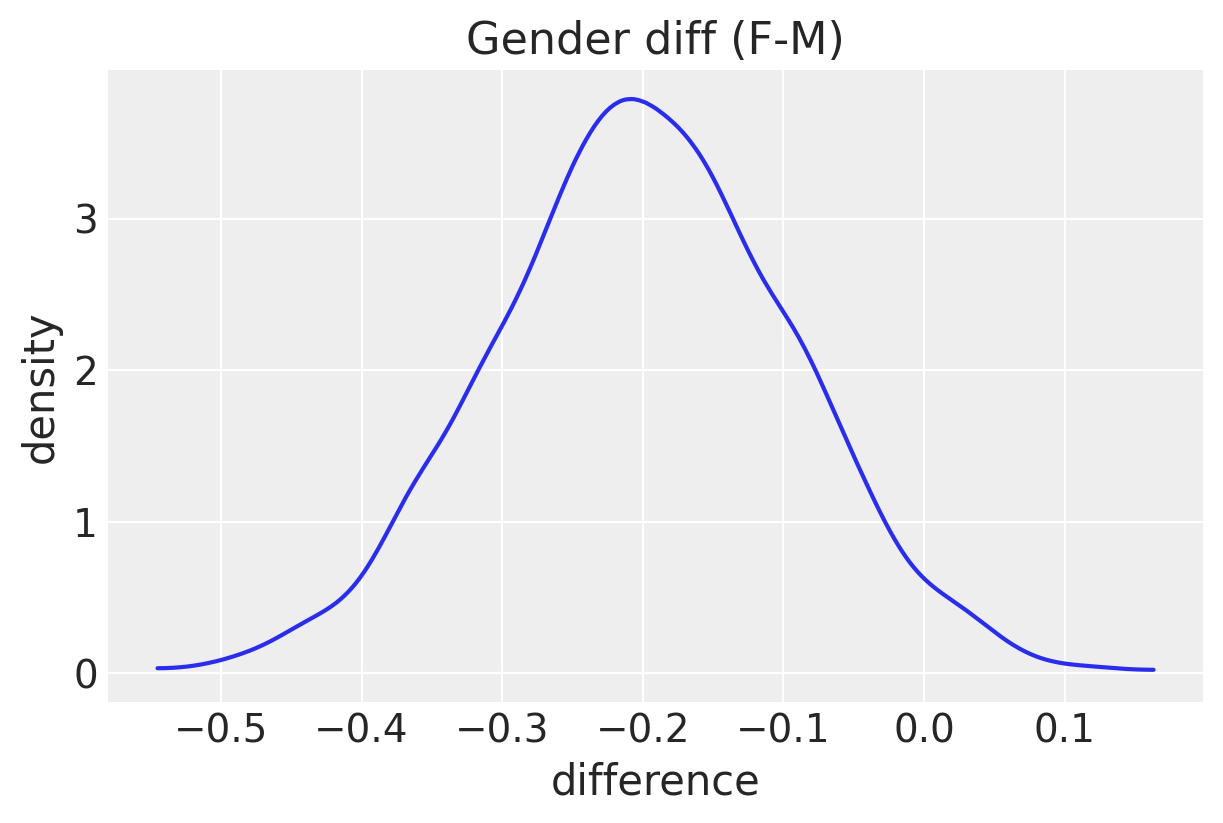

<IPython.core.display.Javascript object>

In [246]:
f, ax1 = plt.subplots(figsize=(6, 4))
# sns.kdeplot(idata_mq1b_df[('posterior', 'a[1]', 1)] - idata_mq1b_df[('posterior', 'a[0]', 0)])
az.plot_kde(idata_mq1b_df[('posterior', 'a[1]', 1)] - idata_mq1b_df[('posterior', 'a[0]', 0)], ax=ax1)
ax1.set(xlabel='difference', ylabel='density', title='Gender diff (F-M)')

# Q2

Now estimate the DIRECT causal effect of gender on grant awards. Compute the average direct causal effect of gender, weighting each discipline in proportion to the number of applications in the sample. Refer to the marginal effect example in Lecture 9 for help.

## Answer


We'd have to stratify by the discipline to get the direct effect of gender. To get the marginal effect, we would apply simulations as the code shows at the end of lecture 9. Let's do one at a time. 


In [47]:
df_grants.head()

,discipline,gender,applications,awards,gender_ind,discipline_ind
0,Chemical sciences,m,83,22,0,0
1,Chemical sciences,f,39,10,1,0
2,Physical sciences,m,135,26,0,5
3,Physical sciences,f,39,9,1,5
4,Physics,m,67,18,0,6


<IPython.core.display.Javascript object>

In [49]:
n_disc = len(df_grants['discipline_ind'].unique())

<IPython.core.display.Javascript object>

In [50]:
# model without weighting
with pm.Model() as mq2a:

    # Priors
    a = pm.Normal("a", mu=0, sd=1.5, shape=2)
    b = pm.Normal("b", mu=0, sd=1.5, shape=n_disc)

    # linear model (mu is deterministic)
    p = pm.Deterministic("p", pm.math.invlogit(a[df_grants["gender_ind"]] + b[df_grants["discipline_ind"]]))

    # likelihood
    award = pm.Binomial("award", n=df_grants['applications'], p=p, observed=df_grants['awards'])

    # generate posterior and sample
    idata_mq2a = pm.sample(1000, tune=1000, return_inferencedata=True, progressbar=False)


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]
INFO:pymc3:NUTS: [b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.6855137654208409, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8827316509044565, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

array([[<AxesSubplot:title={'center':'b\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'b\n3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n5'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'b\n6'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n7'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'b\n8'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

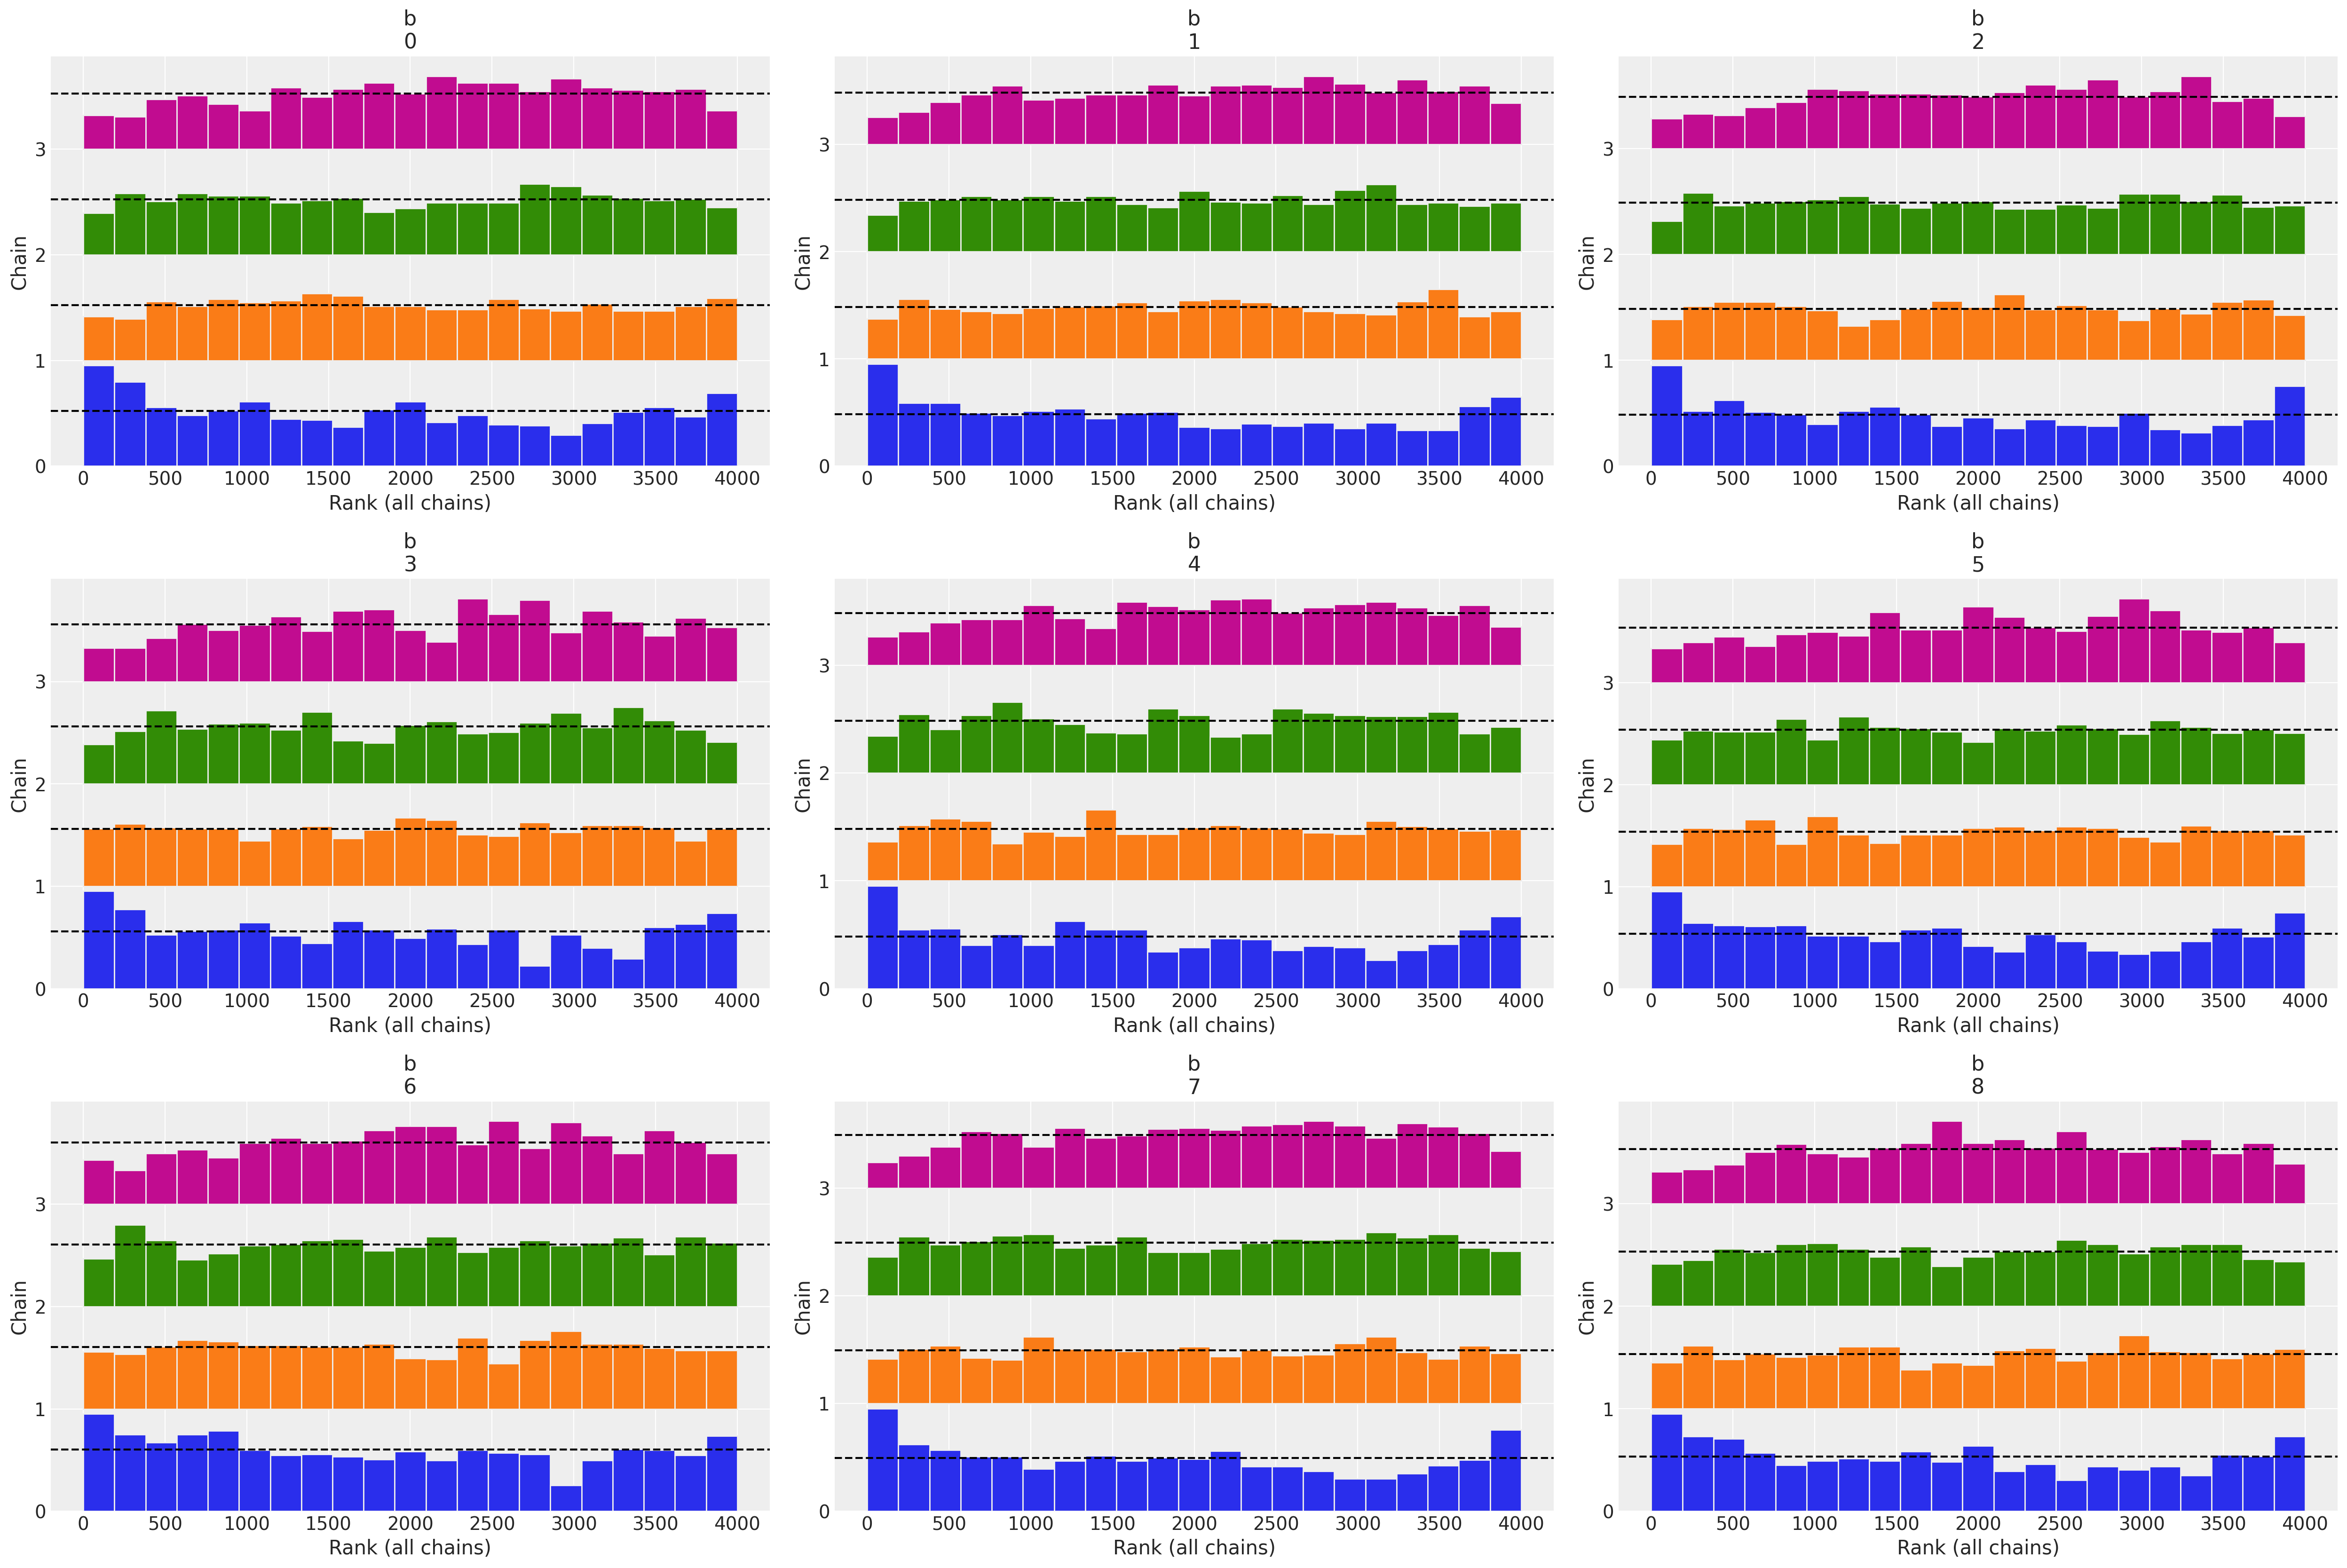

<IPython.core.display.Javascript object>

In [124]:
az.plot_rank(idata_mq2a, var_names=['b'])

How to do it the index way?

Text(0.5, 1.0, 'direct effect of gender')

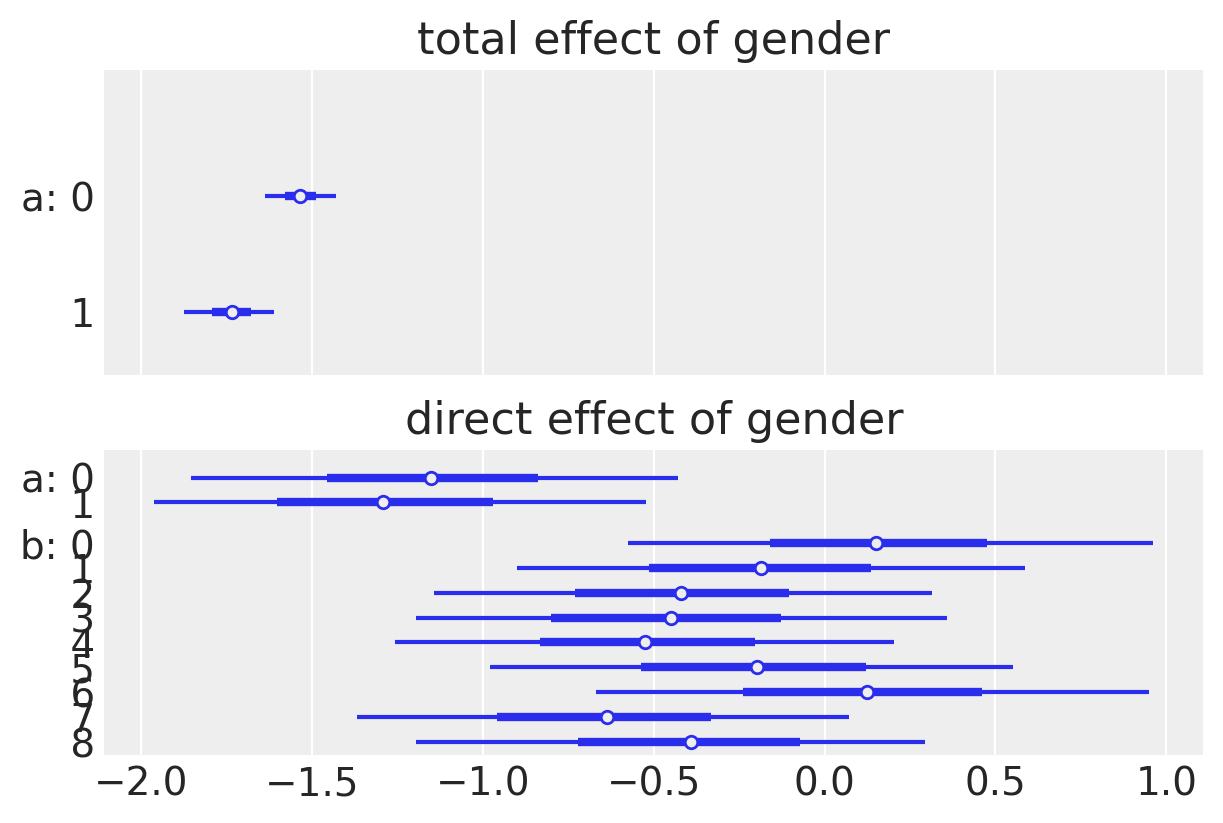

<IPython.core.display.Javascript object>

In [51]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
az.plot_forest(idata_mq1b, var_names=['a'], combined=True, ax=ax1)
ax1.set_title("total effect of gender")

az.plot_forest(idata_mq2a, var_names=['a', 'b'], combined=True, ax=ax2)
ax2.set_title("direct effect of gender")

In [55]:
idata_mq1b_df = idata_mq1b.to_dataframe()
idata_mq2a_df = idata_mq2a.to_dataframe()
# idata_mq2a_df.head()
idata_mq2a_df.columns


Index([                               'chain',
                                       'draw',
                     ('posterior', 'a[0]', 0),
                     ('posterior', 'a[1]', 1),
                     ('posterior', 'b[0]', 0),
                     ('posterior', 'b[1]', 1),
                     ('posterior', 'b[2]', 2),
                     ('posterior', 'b[3]', 3),
                     ('posterior', 'b[4]', 4),
                     ('posterior', 'b[5]', 5),
                     ('posterior', 'b[6]', 6),
                     ('posterior', 'b[7]', 7),
                     ('posterior', 'b[8]', 8),
                     ('posterior', 'p[0]', 0),
                   ('posterior', 'p[10]', 10),
                   ('posterior', 'p[11]', 11),
                   ('posterior', 'p[12]', 12),
                   ('posterior', 'p[13]', 13),
                   ('posterior', 'p[14]', 14),
                   ('posterior', 'p[15]', 15),
                   ('posterior', 'p[16]', 16),
             

<IPython.core.display.Javascript object>

In [72]:
from scipy import special

<IPython.core.display.Javascript object>

In [70]:
# female - male
diff_g = (
    special.expit(idata_mq1b_df[('posterior', 'a[1]', 1)]).head() - 
    special.expit(idata_mq1b_df[('posterior', 'a[0]', 0)]).head()
)

<IPython.core.display.Javascript object>

In [74]:
idata_mq2a_df.head()

,chain,draw,"(posterior, a[0], 0)","(posterior, a[1], 1)","(posterior, b[0], 0)","(posterior, b[1], 1)","(posterior, b[2], 2)","(posterior, b[3], 3)","(posterior, b[4], 4)","(posterior, b[5], 5)",...,"(sample_stats, step_size_bar)","(sample_stats, energy)","(sample_stats, lp)","(sample_stats, energy_error)","(sample_stats, process_time_diff)","(sample_stats, perf_counter_start)","(sample_stats, mean_tree_accept)","(sample_stats, diverging)","(sample_stats, max_energy_error)","(sample_stats, step_size)"
0,0,0,-0.925691,-1.120938,-0.209506,-0.231735,-0.640253,-0.886962,-0.354712,-0.296026,...,0.229687,78.342099,-73.452050,1.218802,0.000715,75520.713199,0.217390,False,7.732259,0.153182
1,0,1,-0.921880,-0.905313,0.102346,-0.437201,-0.708001,-0.479241,-0.752547,-0.572618,...,0.229687,79.017609,-71.551736,-0.258368,0.000714,75520.714011,0.912001,False,5.080784,0.153182
2,0,2,-1.115442,-1.254201,0.004162,-0.215406,-0.423714,-0.704907,-0.456925,-0.005184,...,0.229687,79.207076,-70.028721,0.163482,0.003718,75520.714883,0.580178,False,17.736567,0.153182
3,0,3,-1.370433,-1.263647,0.244572,0.090537,-0.182101,-0.367207,-0.425736,-0.222637,...,0.229687,78.630847,-71.435611,2.114970,0.002694,75520.718742,0.269829,False,4.923420,0.153182
4,0,4,-1.248224,-1.575565,0.364243,-0.134709,-0.397971,-0.284374,-0.515106,-0.079190,...,0.229687,82.390583,-76.057025,0.463065,0.000715,75520.721542,0.907447,False,-1.854433,0.153182


<IPython.core.display.Javascript object>

In [93]:
df_grants.head()

,discipline,gender,applications,awards,gender_ind,discipline_ind,disc_g,disc_g_code
0,Chemical sciences,m,83,22,0,0,Chemical sciences_m,1
1,Chemical sciences,f,39,10,1,0,Chemical sciences_f,0
2,Physical sciences,m,135,26,0,5,Physical sciences_m,11
3,Physical sciences,f,39,9,1,5,Physical sciences_f,10
4,Physics,m,67,18,0,6,Physics_m,13


<IPython.core.display.Javascript object>

In [99]:
sorted(df_grants['discipline_ind'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8]

<IPython.core.display.Javascript object>

In [118]:
post_diff = dict()
for i in df_grants.index:
    if i % 2 == 0:
        post_diff[df_grants.loc[i, 'discipline']] = idata_mq2a_df[('posterior', f'p[{i+1}]', i+1)] - idata_mq2a_df[('posterior', f'p[{i}]', i)]

<IPython.core.display.Javascript object>

I don't think this is the right way to do it. I think I need the matrix?

In [77]:
import theano
import theano.tensor as tt

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'effect of gender (F-M)\nby discipline')

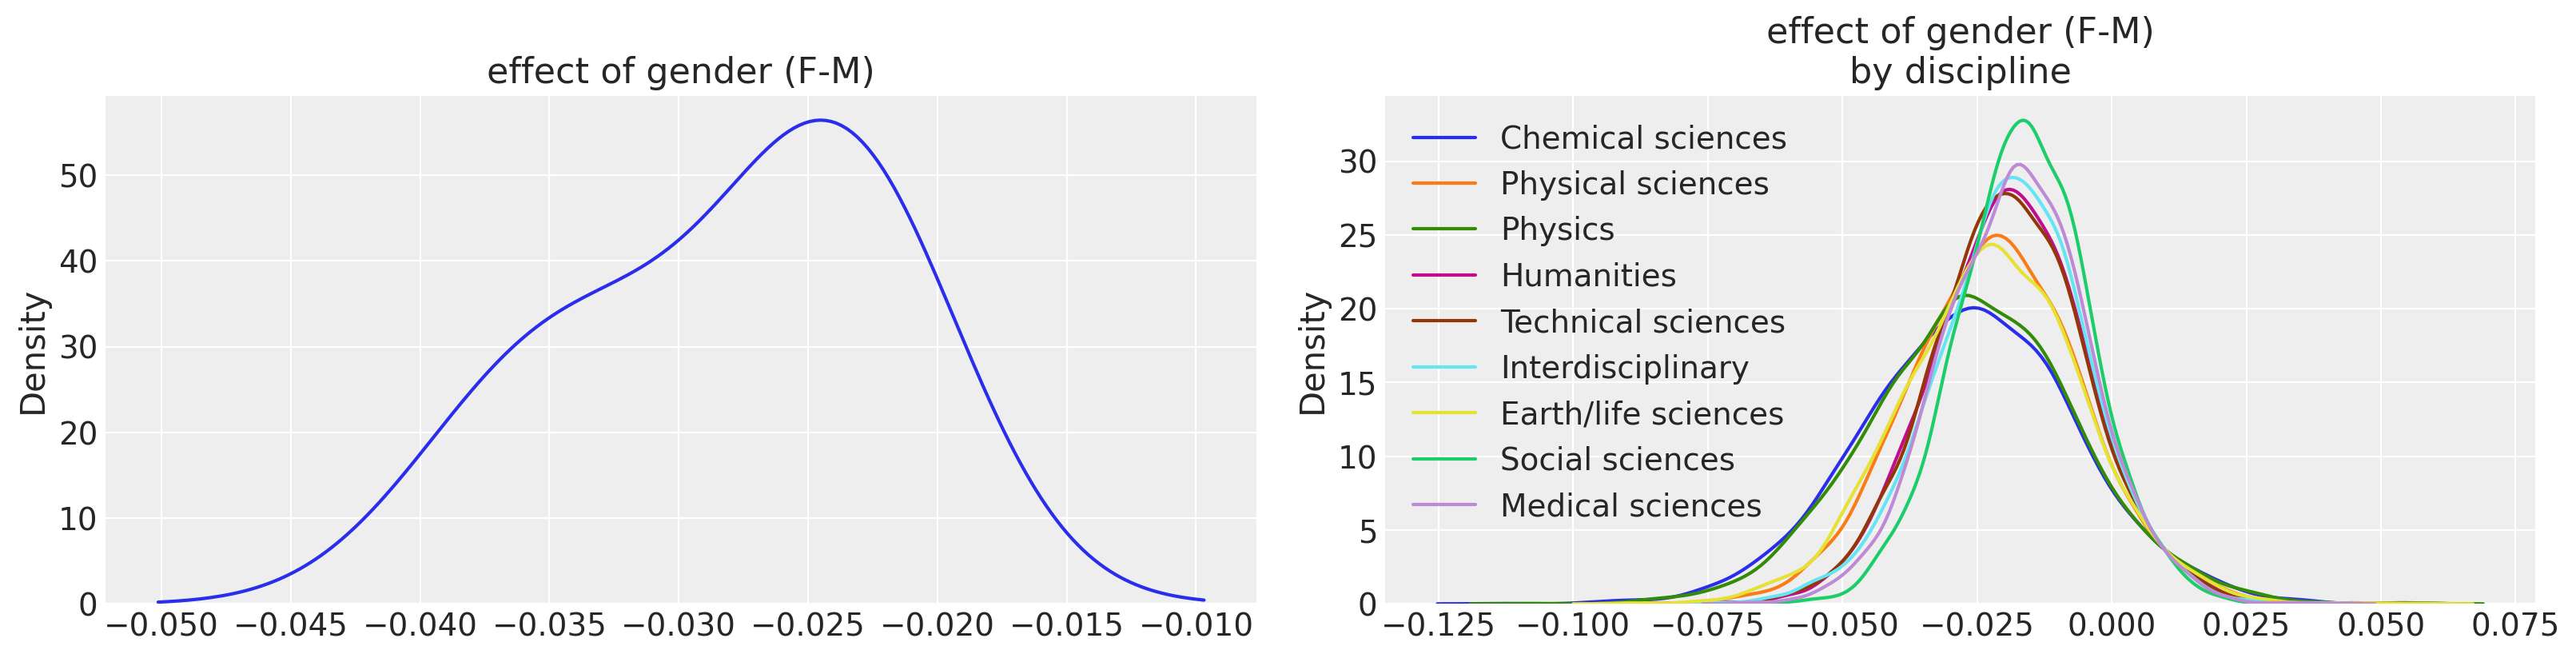

<IPython.core.display.Javascript object>

In [212]:
# same as above by discipline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.kdeplot(diff_g, ax=ax1)
ax1.set_title("effect of gender (F-M)")

for disc in post_diff:
    sns.kdeplot(post_diff[disc], ax=ax2, label=disc)
ax2.legend()
ax2.set_title("effect of gender (F-M)\nby discipline")

## Post-stratification - model with weighting

In [170]:
# number of applications to simulate
total_apps = df_grants['applications'].sum()

# number of applications per discipline
apps_per_disc = df_grants.groupby('discipline').sum()['applications'].reset_index()

<IPython.core.display.Javascript object>

In [171]:
apps_per_disc

,discipline,applications
0,Chemical sciences,122
1,Earth/life sciences,282
2,Humanities,396
3,Interdisciplinary,183
4,Medical sciences,505
5,Physical sciences,174
6,Physics,76
7,Social sciences,834
8,Technical sciences,251


<IPython.core.display.Javascript object>

In [174]:
app_list = list()
for i in apps_per_disc.index:
    app_list += ([i] * apps_per_disc.loc[i, 'applications'])

<IPython.core.display.Javascript object>

In [177]:
df_g0 = pd.DataFrame(
    {
        "D": app_list,
        "N": [1] * total_apps,
        "G": [0] * total_apps,
    }
)

df_g1 = pd.DataFrame(
    {
        "D": app_list,
        "N": [1] * total_apps,
        "G": [1] * total_apps,
    }
)

<IPython.core.display.Javascript object>

In [201]:
# Initialize for speed
p_G0 = np.zeros((len(df_g0), len(idata_mq2a_df)))
p_G1 = np.zeros((len(df_g1), len(idata_mq2a_df)))

<IPython.core.display.Javascript object>

In [206]:
# Dataframe is the same between genders, so use just one to get discipline and apply it to both
for i in range(len(df_g0)):
    disc = df_g0.loc[i, 'D']
    p_G0[i, :] = expit(idata_mq2a_df[('posterior', 'a[0]', 0)] + idata_mq2a_df[('posterior', f'b[{disc}]', disc)])
    p_G1[i, :] = expit(idata_mq2a_df[('posterior', 'a[1]', 1)] + idata_mq2a_df[('posterior', f'b[{disc}]', disc)])

<IPython.core.display.Javascript object>

In [222]:
# Make weights based on number of applications

w = df_grants.groupby('discipline').sum()['awards'] / df_grants.groupby('discipline').sum()['applications']
w = w/max(w)
w

discipline
Chemical sciences      0.996721
Earth/life sciences    0.754610
Humanities             0.623737
Interdisciplinary      0.602186
Medical sciences       0.564356
Physical sciences      0.764368
Physics                1.000000
Social sciences        0.510312
Technical sciences     0.650996
dtype: float64

<IPython.core.display.Javascript object>

In [253]:
# az.plot_kde((p_G1 - p_G0)[0, :])

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'effect of gender (F-M)\nby discipline (with weight)')

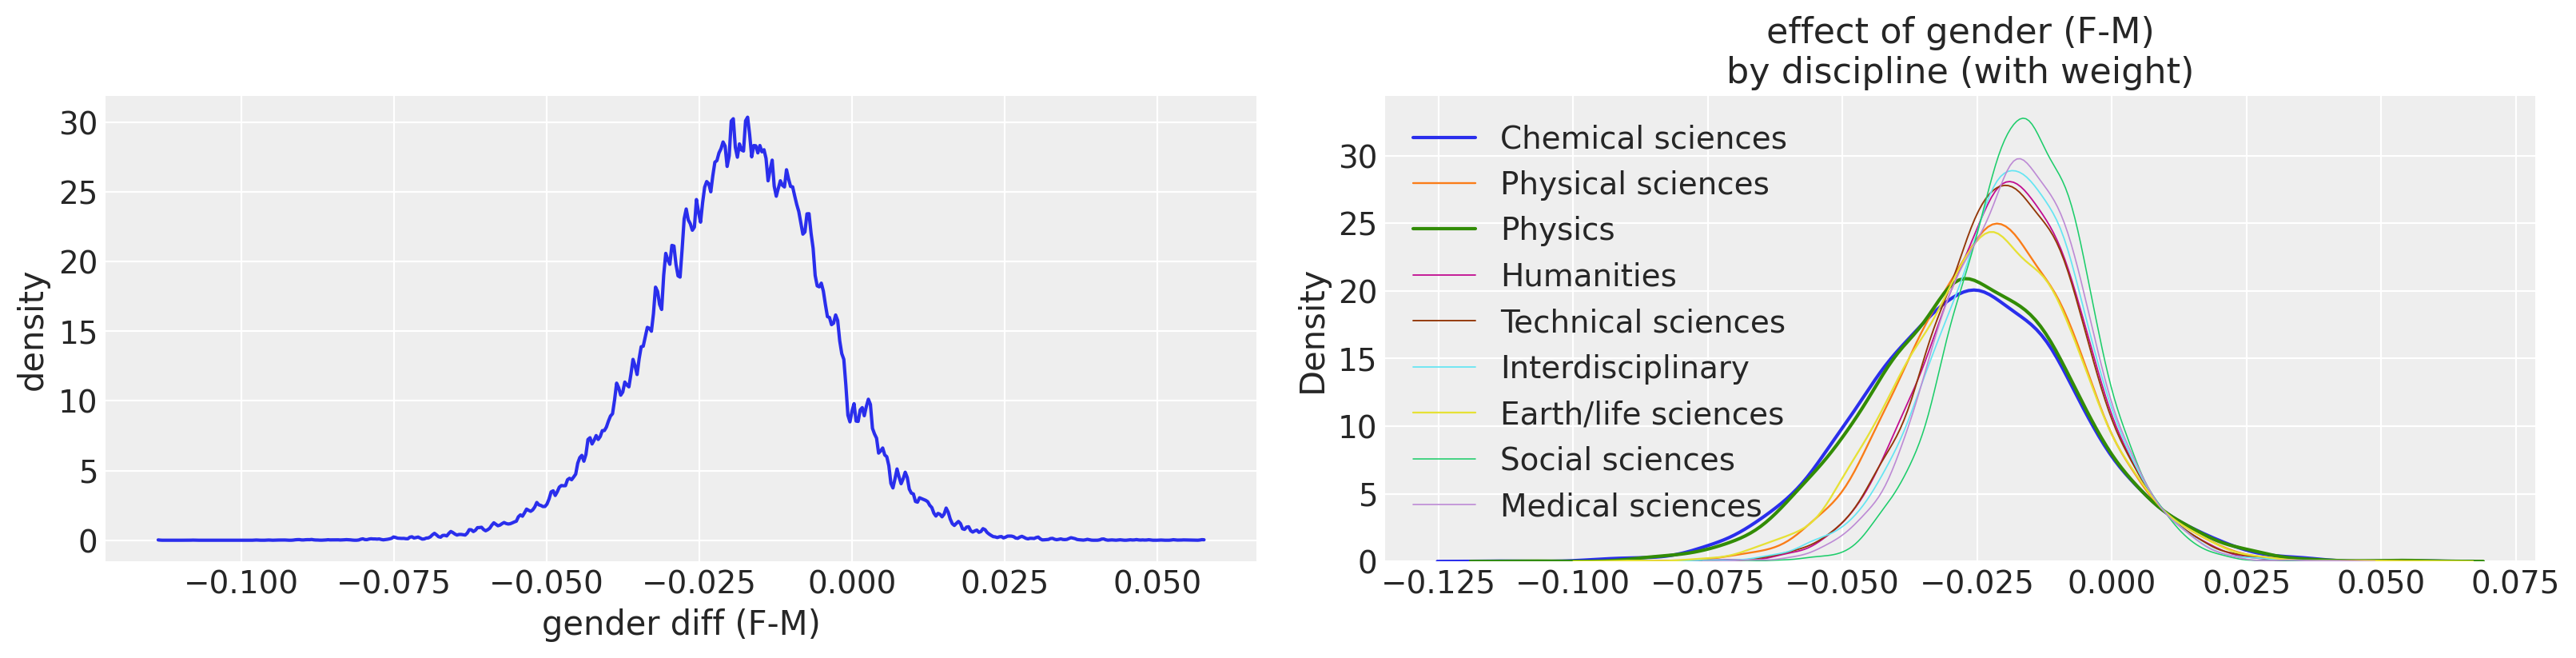

<IPython.core.display.Javascript object>

In [236]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
az.plot_kde(p_G1 - p_G0, ax=ax1)
ax1.set(xlabel='gender diff (F-M)', ylabel='density', title='')

for disc in post_diff:
    sns.kdeplot(post_diff[disc], linewidth=0.5+w[disc]**4, ax=ax2, label=disc)
ax2.legend()
ax2.set_title("effect of gender (F-M)\nby discipline (with weight)")

# Q3

Considering the total effect (problem 1) and direct effect (problem 2) of gender, what causes contribute to the average difference between women and men in award
rate in this sample? It is not necessary to say whether or not there is evidence of discrimination. Simply explain how the direct effects you have estimated make sense
(or not) of the total effect.

## Answer

In [256]:
az.summary(np.array(idata_mq1b_df[('posterior', 'a[1]', 1)] - idata_mq1b_df[('posterior', 'a[0]', 0)]))

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,-0.201,0.106,-0.367,-0.031,0.002,0.001,3663.0,3573.0,3661.0,2989.0,NaN


<IPython.core.display.Javascript object>

In [257]:
az.summary(p_G1 - p_G0)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,-0.019,0.015,-0.042,0.004,0.0,0.0,302578.0,82734.0,474776.0,116866.0,1.02


<IPython.core.display.Javascript object>

The total effect difference (F-M) was about -0.2 while the direct effect -0.02. This means that there is likely more explanations through the indirect or possibly other paths.


# Q4 (optional)

The data in data(UFClefties) are the outcomes
of 205 Ultimate Fighting Championship (UFC) matches (see ?UFClefties for details).
It is widely believed that left-handed fighters (aka “Southpaws”) have an advantage
against right-handed fighters, and left-handed men are indeed over-represented
among fighters (and fencers and tennis players) compared to the general
population. Estimate the average advantage, if any, that a left-handed fighter has
against right-handed fighters. Based upon your estimate, why do you think lefthanders
are over-represented among UFC fighters?

## Answer

(didn't have time)

Appendix: Environment and system parameters

In [254]:
%watermark -n -u -v -iv -w

Last updated: Tue Feb 08 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

matplotlib : 3.3.4
pymc3      : 3.11.0
arviz      : 0.11.1
pandas     : 1.2.1
daft       : 0.1.0
seaborn    : 0.11.1
theano     : 1.1.0
scipy      : 1.6.0
numpy      : 1.20.1
statsmodels: 0.12.2
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]

Watermark: 2.1.0



<IPython.core.display.Javascript object>